# **Big Data Intelligence Project - TMALL Repeat Buyers**
### **Armando Fortes, David Pissarra, Gabriele Oliaro**

In [36]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from xgboost import XGBClassifier, DMatrix
from xgboost import train, plot_importance
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

### Constants and Hyperparameters

In [2]:
DATA_DIR_1 = '../data_format1/'
DATA_DIR_2 = '../data_format2/'
TRAIN_PATH = DATA_DIR_1 + 'train_format1.csv'
TEST_PATH = DATA_DIR_1 + 'test_format1.csv'
USER_INFO_PATH = DATA_DIR_1 + 'user_info_format1.csv'
USER_LOG_PATH = DATA_DIR_1 + 'user_log_format1.csv'
DOUBLE11_DAY = 184

In [3]:
VALID_SET_SIZE = 0.2
PCA_COMPONENTS = 5
RANDOM_SEED = 42
N_FEATURES = 150
EPSILON = 1e-10
SPLITS = 10

## **Data Pre-Processing**

### Read CSVs

In [4]:
df_train = pd.read_csv(TRAIN_PATH)
df_user_info = pd.read_csv(USER_INFO_PATH)
df_user_log = pd.read_csv(USER_LOG_PATH)
df_test = pd.read_csv(TEST_PATH)
df_test.drop('prob', axis=1, inplace=True)

df_train['kind'] = 'train'
df_test['kind'] = 'test'
df = df_train.append(df_test)

### Optimize memory usage and Data Cleaning

In [5]:
print(f'{round(df_user_log.memory_usage().sum() / 2**30, 2)} GB')

2.86 GB


In [6]:
df_user_log['user_id'] = df_user_log['user_id'].astype(np.int32)
df_user_log['item_id'] = df_user_log['item_id'].astype(np.int32)
df_user_log['cat_id'] = df_user_log['cat_id'].astype(np.int16)
df_user_log['seller_id'] = df_user_log['seller_id'].astype(np.int16)
df_user_log.rename(columns={'seller_id' : 'merchant_id'}, inplace=True)
df_user_log['brand_id'].fillna(0, inplace=True)
df_user_log['brand_id'] = df_user_log['brand_id'].astype(np.int16)
df_user_log['time_stamp'] = (pd.to_datetime(df_user_log['time_stamp'], format='%m%d') - pd.to_datetime(df_user_log['time_stamp'].min(), format='%m%d')).dt.days
df_user_log['time_stamp'] = df_user_log['time_stamp'].astype(np.int16)
df_user_log['action_type'] = df_user_log['action_type'].astype(np.int8)

In [7]:
print(f'{round(df_user_log.memory_usage().sum() / 2**30, 2)} GB')

0.87 GB


In [8]:
df_user_log['time_stamp'].min()

0

In [9]:
df_user_info['age_range'].fillna(0, inplace=True)
df_user_info['gender'].fillna(2, inplace=True)
df_user_info['age_range'] = df_user_info['age_range'].astype(np.int8)
df_user_info['gender'] = df_user_info['gender'].astype(np.int8)

## **Feature Engineering**

In [10]:
users = df_user_log.groupby('user_id')
merchants = df_user_log.groupby('merchant_id')
users_merchants = df_user_log.groupby(['user_id', 'merchant_id'])
df_user_log['time_period'] = df_user_log['time_stamp'] // 31

double11 = (df_user_log[df_user_log['time_stamp'] == DOUBLE11_DAY]).reset_index(drop=True)
double11_users = double11.groupby('user_id')
double11_merchants = double11.groupby('merchant_id')
double11_users_merchants = double11.groupby(['user_id', 'merchant_id'])

### General counting and ratio features

In [11]:
# transform age categorical features into different binary features
to_merge = pd.get_dummies(df_user_info, prefix='age', columns=['age_range'])
df = df.merge(to_merge, on='user_id', how='left')

# count total number of unique values from each feature for a given user 
to_merge = users.nunique().reset_index().rename(columns={
    'item_id': 'items_user', 
    'cat_id': 'categories_user',
    'merchant_id': 'merchants_user',
    'brand_id': 'brands_user',
    'time_stamp': 'dates_user',
    'time_period': 'periods_user',
    'action_type': 'action_types_user'
    })
df = df.merge(to_merge, on='user_id', how='left')

# count total number of unique values from each feature for a given merchant 
to_merge = merchants.nunique().reset_index().rename(columns={
    'item_id': 'items_merchant', 
    'cat_id': 'categories_merchant',
    'user_id': 'users_merchant',
    'brand_id': 'brands_merchant',
    'time_stamp': 'dates_merchant',
    'time_period': 'periods_merchant',
    'action_type': 'action_types_merchant'
    })
df = df.merge(to_merge, on='merchant_id', how='left')

# count total number of unique values from each feature for a given user and merchant
to_merge = users_merchants.nunique().reset_index().rename(columns={
    'item_id': 'items_user_merchant', 
    'cat_id': 'categories_user_merchant',
    'brand_id': 'brands_user_merchant',
    'time_stamp': 'dates_user_merchant',
    'time_period': 'periods_user_merchant',
    'action_type': 'action_types_user_merchant'
    })
df = df.merge(to_merge, on=['user_id', 'merchant_id'], how='left')

# count total actions by type for a given user
to_merge = users['action_type'].value_counts().unstack(fill_value=0).rename(columns={
    0: 'clicks_user',
    1: 'carts_user',
    2: 'purchases_user',
    3: 'favourites_user'
    })
df = df.merge(to_merge, on='user_id', how='left')

# count total actions by type for a given merchant
to_merge = merchants['action_type'].value_counts().unstack(fill_value=0).rename(columns={
    0: 'clicks_merchant', 
    1: 'carts_merchant',
    2: 'purchases_merchant',
    3: 'favourites_merchant'
    })
df = df.merge(to_merge, on='merchant_id', how='left')

# count total actions by type for a given pair (user, merchant)
to_merge = users_merchants['action_type'].value_counts().unstack(fill_value=0).rename(columns={
    0: 'clicks_user_merchant',
    1: 'carts_user_merchant',
    2: 'purchases_user_merchant',
    3: 'favourites_user_merchant'
    })
df = df.merge(to_merge, on=['user_id', 'merchant_id'], how='left')

# ratio of actions in each merchant (user perspective)
df['clicks_in_merchant_ratio_perspective'] = df['clicks_user_merchant'] / (df['clicks_user'] + EPSILON)
df['carts_in_merchant_ratio_perspective'] = df['carts_user_merchant'] / (df['carts_user'] + EPSILON)
df['purchases_in_merchant_ratio_perspective'] = df['purchases_user_merchant'] / (df['purchases_user'] + EPSILON)
df['favourites_in_merchant_ratio_perspective'] = df['favourites_user_merchant'] / (df['favourites_user'] + EPSILON)

# ratio of actions in each merchant (merchant perspective)
df['clicks_by_user_ratio_perspective'] = df['clicks_user_merchant'] / (df['clicks_merchant'] + EPSILON)
df['carts_by_user_ratio_perspective'] = df['carts_user_merchant'] / (df['carts_merchant'] + EPSILON)
df['purchases_by_user_ratio_perspective'] = df['purchases_user_merchant'] / (df['purchases_merchant'] + EPSILON)
df['favourites_by_user_ratio_perspective'] = df['favourites_user_merchant'] / (df['favourites_merchant'] + EPSILON)

# ratio of each action type for a given user
df['clicks_user_ratio'] = df['clicks_user'] / (df['clicks_user'] + df['carts_user'] + df['purchases_user'] + df['favourites_user'] + EPSILON)
df['carts_user_ratio'] = df['carts_user'] / (df['clicks_user'] + df['carts_user'] + df['purchases_user'] + df['favourites_user'] + EPSILON)
df['purchases_user_ratio'] = df['purchases_user'] / (df['clicks_user'] + df['carts_user'] + df['purchases_user'] + df['favourites_user'] + EPSILON)
df['favourites_user_ratio'] = df['favourites_user'] / (df['clicks_user'] + df['carts_user'] + df['purchases_user'] + df['favourites_user'] + EPSILON)

# ratio of each action type for a given merchant
df['clicks_merchant_ratio'] = df['clicks_merchant'] / (df['clicks_merchant'] + df['carts_merchant'] + df['purchases_merchant'] + df['favourites_merchant'] + EPSILON)
df['carts_merchant_ratio'] = df['carts_merchant'] / (df['clicks_merchant'] + df['carts_merchant'] + df['purchases_merchant'] + df['favourites_merchant'] + EPSILON)
df['purchases_merchant_ratio'] = df['purchases_merchant'] / (df['clicks_merchant'] + df['carts_merchant'] + df['purchases_merchant'] + df['favourites_merchant'] + EPSILON)
df['favourites_merchant_ratio'] = df['favourites_merchant'] / (df['clicks_merchant'] + df['carts_merchant'] + df['purchases_merchant'] + df['favourites_merchant'] + EPSILON)

# ratio of each action type for a given pair (user, merchant)
df['clicks_user_merchant_ratio'] = df['clicks_user_merchant'] / (df['clicks_user_merchant'] + df['carts_user_merchant'] + df['purchases_user_merchant'] + df['favourites_user_merchant'] + EPSILON)
df['carts_user_merchant_ratio'] = df['carts_user_merchant'] / (df['clicks_user_merchant'] + df['carts_user_merchant'] + df['purchases_user_merchant'] + df['favourites_user_merchant'] + EPSILON)
df['purchases_user_merchant_ratio'] = df['purchases_user_merchant'] / (df['clicks_user_merchant'] + df['carts_user_merchant'] + df['purchases_user_merchant'] + df['favourites_user_merchant'] + EPSILON)
df['favourites_user_merchant_ratio'] = df['favourites_user_merchant'] / (df['clicks_user_merchant'] + df['carts_user_merchant'] + df['purchases_user_merchant'] + df['favourites_user_merchant'] + EPSILON)

# interval features
to_merge = (users['time_stamp'].max() - users['time_stamp'].min()).rename('interval')
df = df.merge(to_merge, on='user_id', how='left')

### Monthly Features

Users

In [12]:
def trendline(x, y):
    n = x.shape[1]
    sum_x = np.sum(x)
    sum_x_2 = np.sum(x**2)
    sum_y = np.sum(y, axis=1)
    u = (n * np.dot(y, x.T)) - (sum_x * sum_y).reshape(-1, 1)
    l = np.sum(sum_x_2) - (sum_x ** 2)
    return (u / l)

In [13]:
users_time = df_user_log.groupby(['user_id', 'time_period'])

to_merge = users_time['action_type'].value_counts().unstack(fill_value=0).rename(columns={
    0: 'clicks_user',
    1: 'carts_user',
    2: 'purchases_user',
    3: 'favourites_user'
    }).reset_index()

to_merge_aux = to_merge.groupby('user_id').max().drop('time_period', axis=1).rename(columns={
    'clicks_user': 'clicks_user_period_max',
    'carts_user': 'carts_user_period_max',
    'purchases_user': 'purchases_user_period_max',
    'favourites_user': 'favourites_user_period_max'
})
df = df.merge(to_merge_aux, on='user_id', how='left')
to_merge_aux = to_merge.groupby('user_id').mean().drop('time_period', axis=1).rename(columns={
    'clicks_user': 'clicks_user_period_mean',
    'carts_user': 'carts_user_period_mean',
    'purchases_user': 'purchases_user_period_mean',
    'favourites_user': 'favourites_user_period_mean'
})
df = df.merge(to_merge_aux, on='user_id', how='left')
to_merge_aux = to_merge.groupby('user_id').std().drop('time_period', axis=1).rename(columns={
    'clicks_user': 'clicks_user_period_std',
    'carts_user': 'carts_user_period_std',
    'purchases_user': 'purchases_user_period_std',
    'favourites_user': 'favourites_user_period_std'
}).fillna(0)
df = df.merge(to_merge_aux, on='user_id', how='left')
to_merge_aux = to_merge.groupby('user_id').median().drop('time_period', axis=1).rename(columns={
    'clicks_user': 'clicks_user_period_median',
    'carts_user': 'carts_user_period_median',
    'purchases_user': 'purchases_user_period_median',
    'favourites_user': 'favourites_user_period_median'
})
df = df.merge(to_merge_aux, on='user_id', how='left')

to_merge = to_merge.groupby(['user_id', 'time_period']).sum().unstack().fillna(0).stack().reset_index()
to_merge = to_merge.pivot_table(values=['clicks_user', 'carts_user', 'purchases_user', 'favourites_user'], index='user_id', columns='time_period')
to_merge.columns = ['_period_'.join(str(x) for x in col) for col in to_merge.columns.values]
df = df.merge(to_merge, on='user_id', how='left')

In [14]:
# users trendline
purchase_col = [col for col in df if col.startswith('purchases_user_period') and col[-1].isdigit()]
x = np.array([int(col[-1]) for col in purchase_col]).reshape(1, -1)
y = df[purchase_col].to_numpy()
df['purchase_user_trendline'] = trendline(x, y)

clicks_col = [col for col in df if col.startswith('clicks_user_period') and col[-1].isdigit()]
y = df[clicks_col].to_numpy()
df['clicks_user_trendline'] = trendline(x, y)

carts_col = [col for col in df if col.startswith('carts_user_period') and col[-1].isdigit()]
y = df[carts_col].to_numpy()
df['carts_user_trendline'] = trendline(x, y)

favourites_col = [col for col in df if col.startswith('favourites_user_period') and col[-1].isdigit()]
y = df[favourites_col].to_numpy()
df['favourites_user_trendline'] = trendline(x, y)

Merchants

In [15]:
merchants_time = df_user_log.groupby(['merchant_id', 'time_period'])

to_merge = merchants_time['action_type'].value_counts().unstack(fill_value=0).rename(columns={
    0: 'clicks_merchant',
    1: 'carts_merchant',
    2: 'purchases_merchant',
    3: 'favourites_merchant'
    }).reset_index()

to_merge_aux = to_merge.groupby('merchant_id').max().drop('time_period', axis=1).rename(columns={
    'clicks_merchant': 'clicks_merchant_period_max',
    'carts_merchant': 'carts_merchant_period_max',
    'purchases_merchant': 'purchases_merchant_period_max',
    'favourites_merchant': 'favourites_merchant_period_max'
})
df = df.merge(to_merge_aux, on='merchant_id', how='left')
to_merge_aux = to_merge.groupby('merchant_id').mean().drop('time_period', axis=1).rename(columns={
    'clicks_merchant': 'clicks_merchant_period_mean',
    'carts_merchant': 'carts_merchant_period_mean',
    'purchases_merchant': 'purchases_merchant_period_mean',
    'favourites_merchant': 'favourites_merchant_period_mean'
})
df = df.merge(to_merge_aux, on='merchant_id', how='left')
to_merge_aux = to_merge.groupby('merchant_id').std().drop('time_period', axis=1).rename(columns={
    'clicks_merchant': 'clicks_merchant_period_std',
    'carts_merchant': 'carts_merchant_period_std',
    'purchases_merchant': 'purchases_merchant_period_std',
    'favourites_merchant': 'favourites_merchant_period_std'
}).fillna(0)
df = df.merge(to_merge_aux, on='merchant_id', how='left')
to_merge_aux = to_merge.groupby('merchant_id').median().drop('time_period', axis=1).rename(columns={
    'clicks_merchant': 'clicks_merchant_period_median',
    'carts_merchant': 'carts_merchant_period_median',
    'purchases_merchant': 'purchases_merchant_period_median',
    'favourites_merchant': 'favourites_merchant_period_median'
})
df = df.merge(to_merge_aux, on='merchant_id', how='left')

to_merge = to_merge.groupby(['merchant_id', 'time_period']).sum().unstack().fillna(0).stack().reset_index()
to_merge = to_merge.pivot_table(values=['clicks_merchant', 'carts_merchant', 'purchases_merchant', 'favourites_merchant'], index='merchant_id', columns='time_period')
to_merge.columns = ['_period_'.join(str(x) for x in col) for col in to_merge.columns.values]
df = df.merge(to_merge, on='merchant_id', how='left')

In [16]:
# merchants trendline
purchase_col = [col for col in df if col.startswith('purchases_merchant_period') and col[-1].isdigit()]
x = np.array([int(col[-1]) for col in purchase_col]).reshape(1, -1)
y = df[purchase_col].to_numpy()
df['purchase_merchant_trendline'] = trendline(x, y)

clicks_col = [col for col in df if col.startswith('clicks_merchant_period') and col[-1].isdigit()]
y = df[clicks_col].to_numpy()
df['clicks_merchant_trendline'] = trendline(x, y)

carts_col = [col for col in df if col.startswith('carts_merchant_period') and col[-1].isdigit()]
y = df[carts_col].to_numpy()
df['carts_merchant_trendline'] = trendline(x, y)

favourites_col = [col for col in df if col.startswith('favourites_merchant_period') and col[-1].isdigit()]
y = df[favourites_col].to_numpy()
df['favourites_merchant_trendline'] = trendline(x, y)

Users-Merchants

In [17]:
users_merchants_time = df_user_log.groupby(['user_id', 'merchant_id', 'time_period'])

to_merge = users_merchants_time['action_type'].value_counts().unstack(fill_value=0).rename(columns={
    0: 'clicks_user_merchant',
    1: 'carts_user_merchant',
    2: 'purchases_user_merchant',
    3: 'favourites_user_merchant'
    }).reset_index()
to_merge = to_merge.groupby(['user_id', 'merchant_id', 'time_period']).sum().unstack().fillna(0).stack().reset_index()
to_merge = to_merge.pivot_table(values=['clicks_user_merchant', 'carts_user_merchant', 'purchases_user_merchant', 'favourites_user_merchant'], index=['user_id', 'merchant_id'], columns='time_period')
to_merge.columns = ['_period_'.join(str(x) for x in col) for col in to_merge.columns.values]
df = df.merge(to_merge, on=['user_id', 'merchant_id'], how='left')

In [18]:
# user-merchants trendline
purchase_col = [col for col in df if col.startswith('purchases_user_merchant_period') and col[-1].isdigit()]
x = np.array([int(col[-1]) for col in purchase_col]).reshape(1, -1)
y = df[purchase_col].to_numpy()
df['purchase_user_merchant_trendline'] = trendline(x, y)

clicks_col = [col for col in df if col.startswith('clicks_user_merchant_period') and col[-1].isdigit()]
y = df[clicks_col].to_numpy()
df['clicks_user_merchant_trendline'] = trendline(x, y)

carts_col = [col for col in df if col.startswith('carts_user_merchant_period') and col[-1].isdigit()]
y = df[carts_col].to_numpy()
df['carts_user_merchant_trendline'] = trendline(x, y)

favourites_col = [col for col in df if col.startswith('favourites_user_merchant_period') and col[-1].isdigit()]
y = df[favourites_col].to_numpy()
df['favourites_user_merchant_trendline'] = trendline(x, y)

### Double11 Features

Counting Features

In [19]:
# count total number of unique values from each feature for a given user 
to_merge = double11_users.nunique().reset_index().rename(columns={
    'item_id': 'double11_items_user', 
    'cat_id': 'double11_categories_user',
    'merchant_id': 'double11_merchants_user',
    'brand_id': 'double11_brands_user',
    'time_stamp': 'double11_dates_user',
    'time_period': 'double11_periods_user',
    'action_type': 'double11_action_types_user'
    })
df = df.merge(to_merge, on='user_id', how='left')

# count total number of unique values from each feature for a given merchant 
to_merge = double11_merchants.nunique().reset_index().rename(columns={
    'item_id': 'double11_items_merchant', 
    'cat_id': 'double11_categories_merchant',
    'user_id': 'double11_users_merchant',
    'brand_id': 'double11_brands_merchant',
    'time_stamp': 'double11_dates_merchant',
    'time_period': 'double11_periods_merchant',
    'action_type': 'double11_action_types_merchant'
    })
df = df.merge(to_merge, on='merchant_id', how='left')

# count total number of unique values from each feature for a given user and merchant
to_merge = double11_users_merchants.nunique().reset_index().rename(columns={
    'item_id': 'double11_items_user_merchant', 
    'cat_id': 'double11_categories_user_merchant',
    'brand_id': 'double11_brands_user_merchant',
    'time_stamp': 'double11_dates_user_merchant',
    'time_period': 'double11_periods_user_merchant',
    'action_type': 'double11_action_types_user_merchant'
    })
df = df.merge(to_merge, on=['user_id', 'merchant_id'], how='left')

# count total actions by type for a given user
to_merge = double11_users['action_type'].value_counts().unstack(fill_value=0).rename(columns={
    0: 'double11_clicks_user',
    1: 'double11_carts_user',
    2: 'double11_purchases_user',
    3: 'double11_favourites_user'
    })
df = df.merge(to_merge, on='user_id', how='left')

# count total actions by type for a given merchant
to_merge = double11_merchants['action_type'].value_counts().unstack(fill_value=0).rename(columns={
    0: 'double11_clicks_merchant', 
    1: 'double11_carts_merchant',
    2: 'double11_purchases_merchant',
    3: 'double11_favourites_merchant'
    })
df = df.merge(to_merge, on='merchant_id', how='left')

# count total actions by type for a given pair (user, merchant)
to_merge = double11_users_merchants['action_type'].value_counts().unstack(fill_value=0).rename(columns={
    0: 'double11_clicks_user_merchant',
    1: 'double11_carts_user_merchant',
    2: 'double11_purchases_user_merchant',
    3: 'double11_favourites_user_merchant'
    })
df = df.merge(to_merge, on=['user_id', 'merchant_id'], how='left')

Ratio Features

In [20]:
# double11 user features compared to total features
df['double11_items_user_ratio'] = df['double11_items_user'] / (df['items_user'] + EPSILON)
df['double11_categories_user_ratio'] = df['double11_categories_user'] / (df['categories_user'] + EPSILON)
df['double11_merchants_user_ratio'] = df['double11_merchants_user'] / (df['merchants_user'] + EPSILON)
df['double11_brands_user_ratio'] = df['double11_brands_user'] / (df['brands_user'] + EPSILON)
df['double11_dates_user_ratio'] = df['double11_dates_user'] / (df['dates_user'] + EPSILON)
df['double11_periods_user_ratio'] = df['double11_periods_user'] / (df['periods_user'] + EPSILON)
df['double11_action_types_user_ratio'] = df['double11_action_types_user'] / (df['action_types_user'] + EPSILON)

# double11 merchant features compared to total features
df['double11_items_merchant_ratio'] = df['double11_items_merchant'] / (df['items_merchant'] + EPSILON)
df['double11_categories_merchant_ratio'] = df['double11_categories_merchant'] / (df['categories_merchant'] + EPSILON)
df['double11_users_merchant_ratio'] = df['double11_users_merchant'] / (df['users_merchant'] + EPSILON)
df['double11_brands_merchant_ratio'] = df['double11_brands_merchant'] / (df['brands_merchant'] + EPSILON)
df['double11_dates_merchant_ratio'] = df['double11_dates_merchant'] / (df['dates_merchant'] + EPSILON)
df['double11_periods_merchant_ratio'] = df['double11_periods_merchant'] / (df['periods_merchant'] + EPSILON)
df['double11_action_types_merchant_ratio'] = df['double11_action_types_merchant'] / (df['action_types_merchant'] + EPSILON)

# double11 (user, merchant) features compared to total features
df['double11_items_user_merchant_ratio'] = df['double11_items_user_merchant'] / (df['items_user_merchant'] + EPSILON)
df['double11_categories_user_merchant_ratio'] = df['double11_categories_user_merchant'] / (df['categories_user_merchant'] + EPSILON)
df['double11_brands_user_merchant_ratio'] = df['double11_brands_user_merchant'] / (df['brands_user_merchant'] + EPSILON)
df['double11_dates_user_merchant_ratio'] = df['double11_dates_user_merchant'] / (df['dates_user_merchant'] + EPSILON)
df['double11_periods_user_merchant_ratio'] = df['double11_periods_user_merchant'] / (df['periods_user_merchant'] + EPSILON)
df['double11_action_types_user_merchant_ratio'] = df['double11_action_types_user_merchant'] / (df['action_types_user_merchant'] + EPSILON)

# ratio of actions in each merchant (user perspective)
df['double11_clicks_in_merchant_ratio_perspective'] = df['double11_clicks_user_merchant'] / (df['double11_clicks_user'] + EPSILON)
df['double11_carts_in_merchant_ratio_perspective'] = df['double11_carts_user_merchant'] / (df['double11_carts_user'] + EPSILON)
df['double11_purchases_in_merchant_ratio_perspective'] = df['double11_purchases_user_merchant'] / (df['double11_purchases_user'] + EPSILON)
df['double11_favourites_in_merchant_ratio_perspective'] = df['double11_favourites_user_merchant'] / (df['double11_favourites_user'] + EPSILON)

# ratio of actions in each merchant (merchant perspective)
df['double11_clicks_by_user_ratio_perspective'] = df['double11_clicks_user_merchant'] / (df['double11_clicks_merchant'] + EPSILON)
df['double11_carts_by_user_ratio_perspective'] = df['double11_carts_user_merchant'] / (df['double11_carts_merchant'] + EPSILON)
df['double11_purchases_by_user_ratio_perspective'] = df['double11_purchases_user_merchant'] / (df['double11_purchases_merchant'] + EPSILON)
df['double11_favourites_by_user_ratio_perspective'] = df['double11_favourites_user_merchant'] / (df['double11_favourites_merchant'] + EPSILON)

# ratio of each action type for a given user
df['double11_clicks_user_ratio'] = df['double11_clicks_user'] / (df['double11_clicks_user'] + df['double11_carts_user'] + df['double11_purchases_user'] + df['double11_favourites_user'] + EPSILON)
df['double11_carts_user_ratio'] = df['double11_carts_user'] / (df['double11_clicks_user'] + df['double11_carts_user'] + df['double11_purchases_user'] + df['double11_favourites_user'] + EPSILON)
df['double11_purchases_user_ratio'] = df['double11_purchases_user'] / (df['double11_clicks_user'] + df['double11_carts_user'] + df['double11_purchases_user'] + df['double11_favourites_user'] + EPSILON)
df['double11_favourites_user_ratio'] = df['double11_favourites_user'] / (df['double11_clicks_user'] + df['double11_carts_user'] + df['double11_purchases_user'] + df['double11_favourites_user'] + EPSILON)

# ratio of each action type for a given merchant
df['double11_clicks_merchant_ratio'] = df['double11_clicks_merchant'] / (df['double11_clicks_merchant'] + df['double11_carts_merchant'] + df['double11_purchases_merchant'] + df['double11_favourites_merchant'] + EPSILON)
df['double11_carts_merchant_ratio'] = df['double11_carts_merchant'] / (df['double11_clicks_merchant'] + df['double11_carts_merchant'] + df['double11_purchases_merchant'] + df['double11_favourites_merchant'] + EPSILON)
df['double11_purchases_merchant_ratio'] = df['double11_purchases_merchant'] / (df['double11_clicks_merchant'] + df['double11_carts_merchant'] + df['double11_purchases_merchant'] + df['double11_favourites_merchant'] + EPSILON)
df['double11_favourites_merchant_ratio'] = df['double11_favourites_merchant'] / (df['double11_clicks_merchant'] + df['double11_carts_merchant'] + df['double11_purchases_merchant'] + df['double11_favourites_merchant'] + EPSILON)

# ratio of each action type for a given pair (user, merchant)
df['double11_clicks_user_merchant_ratio'] = df['double11_clicks_user_merchant'] / (df['double11_clicks_user_merchant'] + df['double11_carts_user_merchant'] + df['double11_purchases_user_merchant'] + df['double11_favourites_user_merchant'] + EPSILON)
df['double11_carts_user_merchant_ratio'] = df['double11_carts_user_merchant'] / (df['double11_clicks_user_merchant'] + df['double11_carts_user_merchant'] + df['double11_purchases_user_merchant'] + df['double11_favourites_user_merchant'] + EPSILON)
df['double11_purchases_user_merchant_ratio'] = df['double11_purchases_user_merchant'] / (df['double11_clicks_user_merchant'] + df['double11_carts_user_merchant'] + df['double11_purchases_user_merchant'] + df['double11_favourites_user_merchant'] + EPSILON)
df['double11_favourites_user_merchant_ratio'] = df['double11_favourites_user_merchant'] / (df['double11_clicks_user_merchant'] + df['double11_carts_user_merchant'] + df['double11_purchases_user_merchant'] + df['double11_favourites_user_merchant'] + EPSILON)

### Max, Mean, Standard deviation and Median on user-merchant actions (grouping by users)

In [21]:
clmns = ['clicks_user_merchant', 'carts_user_merchant', 'purchases_user_merchant', 'favourites_user_merchant']

to_merge = df.groupby('user_id')[clmns].max().rename(columns={
    'clicks_user_merchant': 'clicks_user_merchant_max',
    'carts_user_merchant': 'carts_user_merchant_max',
    'purchases_user_merchant': 'purchases_user_merchant_max',
    'favourites_user_merchant': 'favourites_user_merchant_max'
})
df = df.merge(to_merge, on='user_id', how='left')

to_merge = df.groupby('user_id')[clmns].mean().rename(columns={
    'clicks_user_merchant': 'clicks_user_merchant_mean',
    'carts_user_merchant': 'carts_user_merchant_mean',
    'purchases_user_merchant': 'purchases_user_merchant_mean',
    'favourites_user_merchant': 'favourites_user_merchant_mean'
})
df = df.merge(to_merge, on='user_id', how='left')

to_merge = df.groupby('user_id')[clmns].std().rename(columns={
    'clicks_user_merchant': 'clicks_user_merchant_std',
    'carts_user_merchant': 'carts_user_merchant_std',
    'purchases_user_merchant': 'purchases_user_merchant_std',
    'favourites_user_merchant': 'favourites_user_merchant_std'
}).fillna(0)
df = df.merge(to_merge, on='user_id', how='left')

to_merge = df.groupby('user_id')[clmns].median().rename(columns={
    'clicks_user_merchant': 'clicks_user_merchant_median',
    'carts_user_merchant': 'carts_user_merchant_median',
    'purchases_user_merchant': 'purchases_user_merchant_median',
    'favourites_user_merchant': 'favourites_user_merchant_median'
})
df = df.merge(to_merge, on='user_id', how='left')

### Max, Mean, Standard deviation and Median on user-merchant actions (grouping by merchants)

In [22]:
to_merge = df.groupby('merchant_id')[clmns].max().rename(columns={
    'clicks_user_merchant': 'clicks_merchant_user_max',
    'carts_user_merchant': 'carts_merchant_user_max',
    'purchases_user_merchant': 'purchases_merchant_user_max',
    'favourites_user_merchant': 'favourites_merchant_user_max'
})
df = df.merge(to_merge, on='merchant_id', how='left')

to_merge = df.groupby('merchant_id')[clmns].mean().rename(columns={
    'clicks_user_merchant': 'clicks_merchant_user_mean',
    'carts_user_merchant': 'carts_merchant_user_mean',
    'purchases_user_merchant': 'purchases_merchant_user_mean',
    'favourites_user_merchant': 'favourites_merchant_user_mean'
})
df = df.merge(to_merge, on='merchant_id', how='left')

to_merge = df.groupby('merchant_id')[clmns].std().rename(columns={
    'clicks_user_merchant': 'clicks_merchant_user_std',
    'carts_user_merchant': 'carts_merchant_user_std',
    'purchases_user_merchant': 'purchases_merchant_user_std',
    'favourites_user_merchant': 'favourites_merchant_user_std'
}).fillna(0)
df = df.merge(to_merge, on='merchant_id', how='left')

to_merge = df.groupby('merchant_id')[clmns].median().rename(columns={
    'clicks_user_merchant': 'clicks_merchant_user_median',
    'carts_user_merchant': 'carts_merchant_user_median',
    'purchases_user_merchant': 'purchases_merchant_user_median',
    'favourites_user_merchant': 'favourites_merchant_user_median'
})
df = df.merge(to_merge, on='merchant_id', how='left')

In [23]:
df

,user_id,merchant_id,label,kind,gender,age_0,age_1,age_2,age_3,age_4,...,purchases_merchant_user_mean,favourites_merchant_user_mean,clicks_merchant_user_std,carts_merchant_user_std,purchases_merchant_user_std,favourites_merchant_user_std,clicks_merchant_user_median,carts_merchant_user_median,purchases_merchant_user_median,favourites_merchant_user_median
0,34176,3906,0.0,train,0,0,0,0,0,0,...,1.216783,0.650350,28.676916,0.263884,0.640641,2.630425,8.0,0.0,1.0,0.0
1,34176,121,0.0,train,0,0,0,0,0,0,...,1.679844,0.425390,21.306176,0.283098,1.269946,1.430079,8.0,0.0,1.0,0.0
2,34176,4356,1.0,train,0,0,0,0,0,0,...,1.640625,0.125000,4.918381,0.125000,1.173344,0.333333,2.5,0.0,1.0,0.0
3,34176,2217,0.0,train,0,0,0,0,0,0,...,1.109167,0.386250,11.142143,0.154593,0.400811,1.166602,4.0,0.0,1.0,0.0
4,230784,4818,0.0,train,0,1,0,0,0,0,...,1.638418,0.723164,24.059947,0.418602,1.192333,4.435505,10.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522336,228479,3111,NaN,test,0,0,0,0,0,0,...,1.078947,0.125000,5.970413,0.081111,0.294009,0.369580,3.0,0.0,1.0,0.0
522337,97919,2341,NaN,test,1,0,0,0,0,0,...,1.882759,0.075862,6.035638,0.083045,1.488397,0.335053,3.0,0.0,1.0,0.0
522338,97919,3971,NaN,test,1,0,0,0,0,0,...,1.210712,0.288936,8.273209,0.235101,0.544233,0.719238,3.0,0.0,1.0,0.0
522339,32639,3536,NaN,test,0,1,0,0,0,0,...,1.183871,0.117742,7.350840,0.153774,0.621425,0.390528,4.0,0.0,1.0,0.0


### PCA Features

In [24]:
# PCA features
pca_df = df.drop(['kind', 'label'], axis=1)
pca = PCA(n_components=PCA_COMPONENTS)
pca.fit(pca_df)
df = df.join(pd.DataFrame(pca.transform(pca_df), index=pca_df.index).add_prefix('pca_'))

### Finishing Touches

In [25]:
df_train = df[df['kind'] == 'train'].drop(['kind'], axis=1)
df_test = df[df['kind'] == 'test'].drop(['kind', 'label'], axis=1)
X, y = df_train.drop(columns='label'), df_train['label']

In [26]:
X

,user_id,merchant_id,gender,age_0,age_1,age_2,age_3,age_4,age_5,age_6,...,favourites_merchant_user_std,clicks_merchant_user_median,carts_merchant_user_median,purchases_merchant_user_median,favourites_merchant_user_median,pca_0,pca_1,pca_2,pca_3,pca_4
0,34176,3906,0,0,0,0,0,0,0,1,...,2.630425,8.0,0.0,1.0,0.0,-52628.056843,177676.254827,-6269.319168,-619.284638,-1016.640564
1,34176,121,0,0,0,0,0,0,0,1,...,1.430079,8.0,0.0,1.0,0.0,31895.307961,177923.330462,13390.539621,-2182.917673,1025.140557
2,34176,4356,0,0,0,0,0,0,0,1,...,0.333333,2.5,0.0,1.0,0.0,-63330.375769,177644.819029,-4425.134851,490.824189,-2757.831882
3,34176,2217,0,0,0,0,0,0,0,1,...,1.166602,4.0,0.0,1.0,0.0,3095.529250,177839.480510,5169.268375,-2578.363645,6836.063431
4,230784,4818,0,1,0,0,0,0,0,0,...,4.435505,10.0,0.0,1.0,0.0,-4477.046777,-18791.614727,13418.587739,824.071929,420.479385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260859,359807,4325,1,0,0,0,0,1,0,0,...,0.560529,4.0,0.0,1.0,0.0,-46235.229045,-147937.495059,-536.522941,-466.111135,-94.861517
260860,294527,3971,1,1,0,0,0,0,0,0,...,0.719238,3.0,0.0,1.0,0.0,-35512.557989,-82625.836165,299.127872,-847.395639,1538.658797
260861,294527,152,1,1,0,0,0,0,0,0,...,0.638111,3.0,0.0,1.0,0.0,-59471.452654,-82695.935416,-707.367979,844.697565,-2097.946743
260862,294527,2537,1,1,0,0,0,0,0,0,...,0.953802,4.0,0.0,1.0,0.0,-12810.603941,-82559.545055,5861.587771,-2072.657349,5778.225075


## **Models**

### Fetch best features
The xgboost object will train the model with all features, then the booster object (returned after training) can calculate which features best contribute for most information gain.

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=VALID_SET_SIZE, random_state=RANDOM_SEED)

dtrain = DMatrix(X_train, label=y_train)
dvalid = DMatrix(X_valid, label=y_valid)
watchlist = [(dvalid, 'valid')]
params = {
    'max_depth': 7,
    'min_child_weight': 200, 
    'colsample_bytree': 0.8, 
    'subsample': 0.8, 
    'eta': 0.04,    
    'seed': RANDOM_SEED,
    'eval_metric': 'auc'
}
booster = train(params, dtrain, num_boost_round=2000, evals=watchlist, early_stopping_rounds=50, verbose_eval=True)
best_features = pd.DataFrame(booster.get_score(importance_type='gain').items(), columns=['features', 'importance'])
best_features = best_features.sort_values(by=['importance'], ascending=False)['features'].to_numpy()[: N_FEATURES]
X = X[best_features]

[0]	valid-auc:0.64470
[1]	valid-auc:0.65598
[2]	valid-auc:0.65786
[3]	valid-auc:0.65970
[4]	valid-auc:0.66217
[5]	valid-auc:0.66288
[6]	valid-auc:0.66563
[7]	valid-auc:0.66517
[8]	valid-auc:0.66735
[9]	valid-auc:0.66686
[10]	valid-auc:0.66735
[11]	valid-auc:0.66885
[12]	valid-auc:0.66972
[13]	valid-auc:0.67044
[14]	valid-auc:0.67126
[15]	valid-auc:0.67137
[16]	valid-auc:0.67183
[17]	valid-auc:0.67261
[18]	valid-auc:0.67322
[19]	valid-auc:0.67428
[20]	valid-auc:0.67548
[21]	valid-auc:0.67616
[22]	valid-auc:0.67597
[23]	valid-auc:0.67600
[24]	valid-auc:0.67672
[25]	valid-auc:0.67697
[26]	valid-auc:0.67718
[27]	valid-auc:0.67728
[28]	valid-auc:0.67747
[29]	valid-auc:0.67768
[30]	valid-auc:0.67764
[31]	valid-auc:0.67787
[32]	valid-auc:0.67845
[33]	valid-auc:0.67870
[34]	valid-auc:0.67930
[35]	valid-auc:0.67962
[36]	valid-auc:0.67997
[37]	valid-auc:0.68008
[38]	valid-auc:0.68036
[39]	valid-auc:0.68059
[40]	valid-auc:0.68041
[41]	valid-auc:0.68069
[42]	valid-auc:0.68088
[43]	valid-auc:0.6812

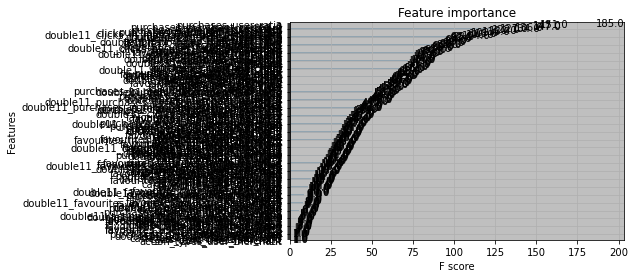

In [37]:
plot_importance(booster=booster)
plt.show()

In [44]:
best = pd.DataFrame(booster.get_score(importance_type='gain').items(), columns=['features', 'importance'])
best = best.sort_values(by=['importance'], ascending=False)
best.head(8)

,features,importance
23,items_user_merchant,5.358978
151,purchases_user_merchant_period_5,5.250384
38,purchases_user_merchant,5.186556
24,categories_user_merchant,4.047388
28,periods_user_merchant,4.018932
192,double11_periods_user_merchant_ratio,2.951180
19,categories_merchant,2.078619
228,favourites_merchant_user_max,2.042979


In [28]:
X

,items_user_merchant,purchases_user_merchant_period_5,purchases_user_merchant,categories_user_merchant,periods_user_merchant,double11_periods_user_merchant_ratio,categories_merchant,favourites_merchant_user_max,purchases_merchant_user_mean,double11_dates_user_merchant_ratio,...,double11_items_user_ratio,double11_brands_user_ratio,clicks_user,double11_favourites_merchant_ratio,favourites_user_ratio,pca_0,clicks_in_merchant_ratio_perspective,favourites_merchant_period_std,action_types_user_merchant,age_0
0,20,1.0,1,6,1,1.0,20,29,1.216783,0.111111,...,0.042969,0.074074,410,0.012834,0.015521,-52628.056843,0.087805,58.564210,3,0
1,1,1.0,1,1,1,1.0,26,17,1.679844,0.333333,...,0.042969,0.074074,410,0.009622,0.015521,31895.307961,0.031707,574.841340,2,0
2,2,6.0,6,1,1,1.0,15,1,1.640625,0.500000,...,0.042969,0.074074,410,0.016563,0.015521,-63330.375769,0.029268,32.849150,2,0
3,1,1.0,1,1,1,1.0,5,37,1.109167,1.000000,...,0.042969,0.074074,410,0.023106,0.015521,3095.529250,0.002439,957.284632,2,0
4,1,1.0,1,1,1,1.0,27,145,1.638418,0.333333,...,0.032258,0.052632,47,0.010259,0.000000,-4477.046777,0.148936,495.571488,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260859,6,2.0,2,2,1,1.0,18,6,1.269430,1.000000,...,0.387755,0.343750,107,0.010207,0.008547,-46235.229045,0.168224,126.233778,2,0
260860,3,1.0,1,1,1,1.0,7,10,1.210712,0.500000,...,0.247191,0.540541,162,0.019422,0.156566,-35512.557989,0.080247,305.298324,3,1
260861,1,1.0,1,1,1,1.0,13,6,1.149254,1.000000,...,0.247191,0.540541,162,0.014428,0.156566,-59471.452654,0.043210,141.972415,3,1
260862,1,1.0,1,1,1,1.0,21,24,1.426554,1.000000,...,0.247191,0.540541,162,0.015551,0.156566,-12810.603941,0.000000,502.194650,1,1


### Models Setup

In [29]:
# TODO tuning
models = {
    'CatBoostClassifier': [CatBoostClassifier, {
        'depth': 6,
        'learning_rate': 0.05,
        'iterations': 1200,
        'eval_metric': 'AUC',
        'random_state': RANDOM_SEED,
        'thread_count': 8,
        'silent': True
    }],
    'LGBMClassifier': [LGBMClassifier, {
        'n_estimators': 2000,
        'max_depth': 8,
        'num_leaves': 50,
        'learning_rate': 0.03,
        'reg_lambda': 1,
        'objective': 'binary',
        'metric': ['auc'],
        'random_state': RANDOM_SEED,
        'n_jobs': -1
    }],
    'XGBClassifier': [XGBClassifier, {
        'max_depth': 7,
        'n_estimators': 1000,
        'min_child_weight': 200,
        'colsample_bytree': 0.8,
        'subsample': 0.8,
        'eta': 0.04,
        'objective': 'binary:logistic',
        'use_label_encoder': False,
        'seed': RANDOM_SEED
    }]
}

### Training + Cross Validation (10Fold)

In [30]:
records = {}
X, y = X.to_numpy(), y.to_numpy() 

for name, model_params in models.items():

    _class, params = model_params
    model_records = {'best_score': 0, 'scores': []}

    kf = KFold(n_splits=SPLITS, shuffle=True, random_state=RANDOM_SEED)

    for train_index, valid_index in kf.split(X):
    
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        model = _class(**params)

        fit_params = {
            'RandomForestClassifier': {}, 
            'CatBoostClassifier': {},
            'LGBMClassifier': {},
            'XGBClassifier': {
                'eval_metric': 'auc',
                'eval_set': [(X_train, y_train), (X_valid, y_valid)],
                'early_stopping_rounds': 50,
                'verbose': False
            }
        }

        model.fit(X_train, y_train, **fit_params[name])
        predictions = model.predict_proba(X_valid)[:,1]
        model_records['scores'].append(roc_auc_score(y_valid, predictions))
        if model_records['scores'][-1] > model_records['best_score']:
            model_records['best_score'] = model_records['scores'][-1]
            model_records['best_instance'] = model

    records[name] = model_records

    print(f'% {name} %')
    print('mean score: {0:.4f}'.format(np.mean(model_records['scores'])))
    print('best score: {0:.4f}'.format(model_records['best_score']))

% CatBoostClassifier %
mean score: 0.6882
best score: 0.7028
% LGBMClassifier %
mean score: 0.6757
best score: 0.6879
% XGBClassifier %
mean score: 0.6916
best score: 0.7067


## **Submission**

### Ensemble Predictions from Best Model Instances

In [61]:
weights = {
    'CatBoostClassifier': 0.35,
    'LGBMClassifier': 0.05,
    'XGBClassifier': 0.60
}

prob_submission = np.zeros(df_test.shape[0])
for name, weight in weights.items():
    prob_submission += records[name]['best_instance'].predict_proba(df_test[best_features].to_numpy())[:, 1]*weight

### Print predictions to CSV

In [62]:
submission = df_test.iloc[:,:2].join(pd.DataFrame(prob_submission, index=df_test.index).rename(columns={0:'prob'}))
submission.to_csv('submission.csv', index=False)